# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# sets the PyHEADTAIL directory etc.
from settings import *

# PyHEADTAIL imports

In [3]:
# optionally: GPU functionality
try:
    import pycuda.autoinit
except ImportError:
    pass

import PyHEADTAIL.spacecharge.spacecharge as sc
from PyHEADTAIL.particles.particles import Particles
from PyHEADTAIL.particles import generators, slicing
from PyHEADTAIL.spacecharge.spacecharge import TransverseGaussianSpaceCharge

PyHEADTAIL v1.10.5.276




# Setting up the machine and functions

In [4]:
# general simulation parameters
n_turns = 20000
n_particles = 10000
n_segments = 1

# machine parameters
circumference = 157.
inj_alpha_x = 0
inj_alpha_y = 0
inj_beta_x = 6.3 # in [m]
inj_beta_y = 5.7 # in [m]
Qx = 5.1
Qy = 6.1
gamma_tr = 4.05
alpha_c_array = [gamma_tr**-2]
V_rf = 8e3 # in [V]
harmonic = 1
phi_offset = 0 # measured from aligned focussing phase (0 or pi)
pipe_radius = 5e-2

# beam parameters
Ekin = 1.4e9 # in [eV]
intensity = 1.684e12
epsn_x = 2.5e-6 # in [m*rad]
epsn_y = 2.5e-6 # in [m*rad]
epsn_z = 1.2 # 4pi*sig_z*sig_dp (*p0/e) in [eVs]

# calculations
gamma = 1 + e * Ekin / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
eta = alpha_c_array[0] - gamma**-2
if eta < 0:
    phi_offset = np.pi - phi_offset
Etot = gamma * m_p * c**2 / e
p0 = np.sqrt(gamma**2 - 1) * m_p * c
Qs = np.sqrt(np.abs(eta) * V_rf / (2 * np.pi * beta**2 * Etot))
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)
turn_period = circumference / (beta * c)

# BETATRON
# Loop on number of segments and create the TransverseSegmentMap
# for each segment.
s = np.arange(0, n_segments + 1) * circumference / n_segments
alpha_x = inj_alpha_x * np.ones(n_segments)
beta_x  = inj_beta_x * np.ones(n_segments)
D_x     = np.zeros(n_segments)
alpha_y = inj_alpha_y * np.ones(n_segments)
beta_y  = inj_beta_y * np.ones(n_segments)
D_y     = np.zeros(n_segments)

# Let's go

Prepare the bunch of which we want to calculate the transverse space charge forces (assuming a Gaussian distribution):

In [5]:
bunch = generators.generate_Gaussian6DTwiss(
    n_particles, intensity, e, m_p, circumference, gamma,
    inj_alpha_x, inj_alpha_y,
    inj_beta_x, inj_beta_y, beta_z,
    epsn_x, epsn_y, epsn_z,
    )

For the `TransverseGaussianSpaceCharge` we need a slicer to calculate the transverse fields for each slice. The `length` argument sets the integration length -- for our demonstration purpose we will use the accelerator `circumference` but for proper tracking one most probably wants to use smaller units (a few divisions per $2\pi$ phase advance).

In [6]:
slicer = slicing.UniformBinSlicer(n_slices=20, n_sigma_z=4)

besc = TransverseGaussianSpaceCharge(slicer, length=circumference)

The horizontal phase space (before kicking with the Bassetti-Erskine space charge formula) looks as:

bunch sizes: sigma_x = 0.00264m, sigma_y = 0.00248m


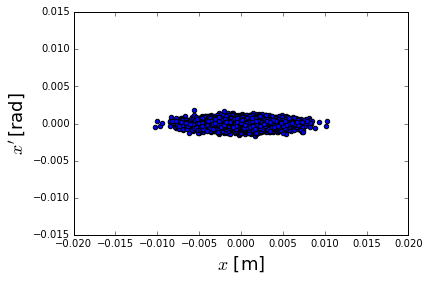

In [7]:
xp0 = bunch.xp.copy()
yp0 = bunch.yp.copy()
plt.scatter(bunch.x, xp0)
plt.xlabel('$x$ [m]', fontsize=18)
plt.ylabel('$x\'$ [rad]', fontsize=18)

print ("bunch sizes: sigma_x = {:.3g}m, sigma_y = {:.3g}m".format(bunch.sigma_x(), bunch.sigma_y()))

The longitudinal profile in terms of the slicer discretisation gives a line charge density of:

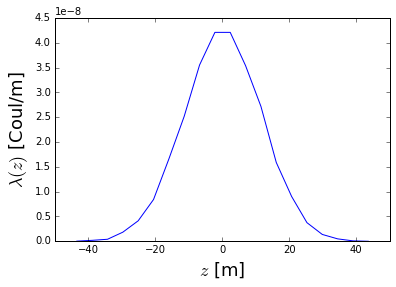

In [8]:
slices = bunch.get_slices(slicer, statistics=["mean_x", "mean_y", "sigma_x", "sigma_y"])

plt.plot(slices.z_centers, slices.lambda_bins(smoothen=False))
plt.xlabel('$z$ [m]', fontsize=18)
plt.ylabel('$\lambda(z)$ [Coul/m]', fontsize=18);

Let's track once and plot the horizontal phase space again after the Bassetti-Erskine space charge kick:

In [9]:
besc.track(bunch)
xp1 = bunch.xp
yp1 = bunch.yp

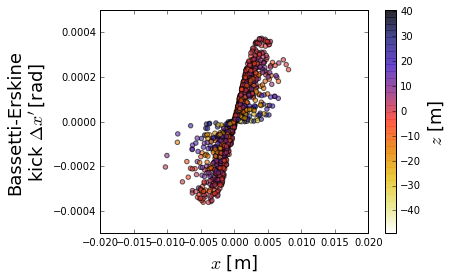

In [10]:
plt.scatter(bunch.x[::10], (xp1 - xp0)[::10], c=bunch.z[::10], cmap=cm.CMRmap_r, alpha=0.6)
plt.ylim(-5e-4, 5e-4)
plt.xlabel('$x$ [m]', fontsize=18)
plt.ylabel("Bassetti-Erskine\n" + r"kick $\Delta x'$ [rad]", fontsize=18)
cbar = plt.colorbar()
cbar.set_label('$z$ [m]', fontsize=18)

$\Longrightarrow$ the central particles around $z\approx 0$ in red have the strongest deflection as the local line charge density is strongest.

PyHEADTAIL embeds various functions to calculate the Bassetti-Erskine formula (or rather the underlying $w(z)$ Faddeeva function), check out https://github.com/PyCOMPLETE/faddeevas for more details.
They all give the same electric field:

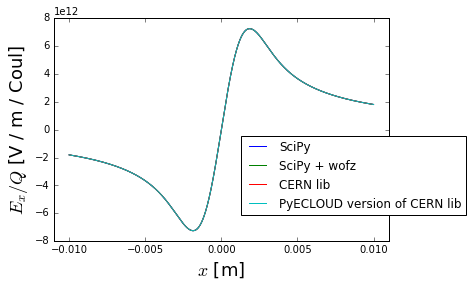

In [11]:
x = np.linspace(-1e-2, 1e-2, 10000)
y = np.zeros(len(x))
sig_x = 1.2e-3
sig_y = 1e-3

plt.plot(x, besc._efieldn_mit(x, y, sig_x, sig_y)[0], label='SciPy')
plt.plot(x, besc._efieldn_mitmod(x, y, sig_x, sig_y)[0], label='SciPy + wofz')
try:
    plt.plot(x, besc._efieldn_koelbig(x, y, sig_x, sig_y)[0], label='CERN lib')
    plt.plot(x, besc._efieldn_pyecloud(x, y, sig_x, sig_y)[0], label='PyECLOUD version of CERN lib')
except ImportError:
    pass
plt.xlim(x[0]*1.1, x[-1]*1.1)
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.xlabel('$x$ [m]', fontsize=18)
plt.ylabel('$E_x / Q$ [V / m / Coul]', fontsize=18);

However, their timings are quite different with the quickest method being the default:

In [12]:
%timeit besc._efieldn_mit(x, y, sig_x, sig_y)

100 loops, best of 3: 2.01 ms per loop


In [13]:
%timeit besc._efieldn_mitmod(x, y, sig_x, sig_y)

100 loops, best of 3: 3.32 ms per loop


In [14]:
%timeit besc._efieldn_koelbig(x, y, sig_x, sig_y)

100 loops, best of 3: 16.3 ms per loop


In [15]:
%timeit besc._efieldn_pyecloud(x, y, sig_x, sig_y)

100 loops, best of 3: 17 ms per loop


For an almost round beam, there can be numerical issues with the usual Bassetti-Erskine formula. Therefore, PyHEADTAIL employs the round-beam formula when $\sigma_x \approx \sigma_y$:

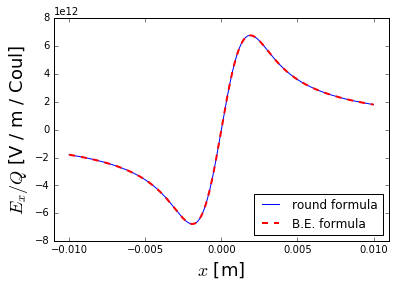

In [16]:
eround_x, _ = besc._efieldn_round(x, y, sig_x)
en_x, _ = besc._efieldn_mit(x, y, sig_x, sig_x * (1-1e-10))
plt.plot(x, eround_x, label='round formula')
plt.plot(x, en_x, 'r--', lw=2, label='B.E. formula')
plt.xlim(x[0]*1.1, x[-1]*1.1)
plt.legend(loc=4)
plt.xlabel('$x$ [m]', fontsize=18)
plt.ylabel('$E_x / Q$ [V / m / Coul]', fontsize=18);

In [17]:
%timeit besc._efieldn_round(x, y, sig_x)

1000 loops, best of 3: 425 µs per loop
